In [1]:
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from pathlib import Path
data_20_percent_path = Path("data/pizza_steak_sushi_20_percent/")
data_20_percent_path

WindowsPath('data/pizza_steak_sushi_20_percent')

In [6]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
# import torchvision

# from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url
# from torchvision import transforms

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# effnet_b2_weights = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

# effnet_b2_transforms = effnet_b2_weights.transforms()
# effnet_b2 = efficientnet_b2(weights="DEFAULT").to(device)


In [25]:
def set_seeds():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

In [26]:
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNet-B2 feature extractor model and transforms."""
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    
    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

In [27]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

In [28]:
from torchinfo import summary
summary(effnetb2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [29]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [30]:
len(train_dataloader), len(test_dataloader), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [31]:
from going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9697 | train_acc: 0.5312 | test_loss: 0.7220 | test_acc: 0.9500
Epoch: 2 | train_loss: 0.7083 | train_acc: 0.8396 | test_loss: 0.5686 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.5583 | train_acc: 0.8750 | test_loss: 0.4873 | test_acc: 0.9256
Epoch: 4 | train_loss: 0.5047 | train_acc: 0.8812 | test_loss: 0.4158 | test_acc: 0.9443
Epoch: 5 | train_loss: 0.4335 | train_acc: 0.8854 | test_loss: 0.3708 | test_acc: 0.9625
Epoch: 6 | train_loss: 0.4333 | train_acc: 0.8875 | test_loss: 0.3426 | test_acc: 0.9290
Epoch: 7 | train_loss: 0.3553 | train_acc: 0.9146 | test_loss: 0.3248 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3442 | train_acc: 0.8688 | test_loss: 0.3376 | test_acc: 0.9227
Epoch: 9 | train_loss: 0.4014 | train_acc: 0.8500 | test_loss: 0.2861 | test_acc: 0.9625
Epoch: 10 | train_loss: 0.3120 | train_acc: 0.8875 | test_loss: 0.2689 | test_acc: 0.9472


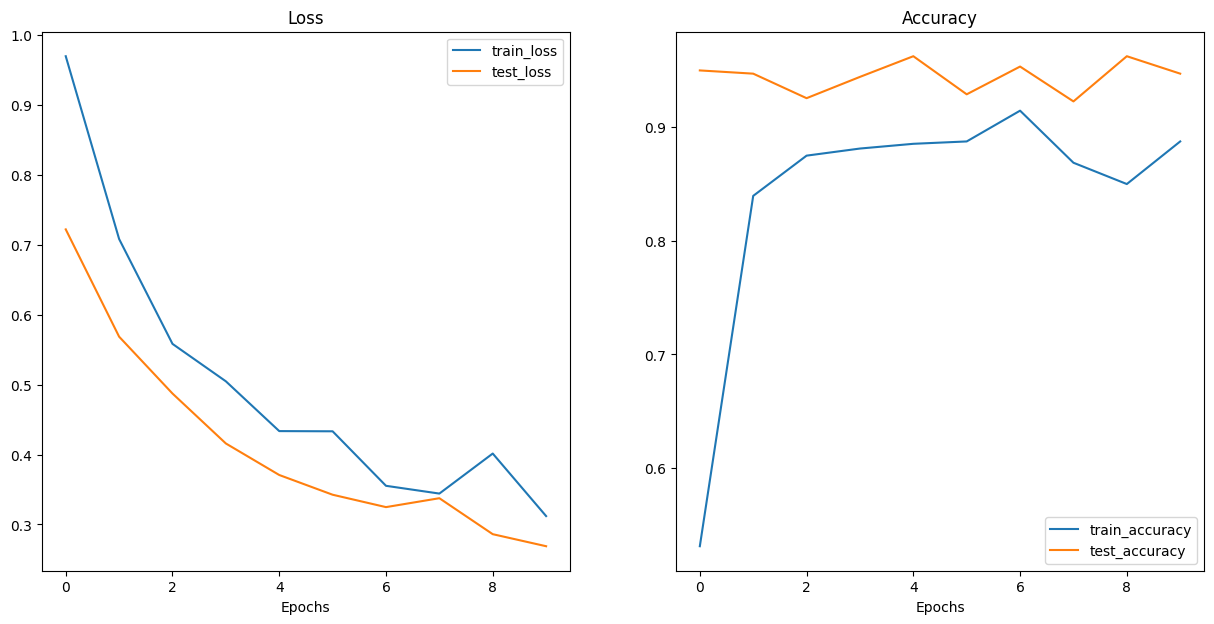

In [32]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [33]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [35]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / 1024 ** 2 # convert bytes to megabytes
print(f"Pretrained EffnetB2 model size: {pretrained_effnetb2_model_size:.2f} MB")

Pretrained EffnetB2 model size: 29.86 MB


In [36]:
# count number of parameters in EffNetB2

effnetb2_params = sum(p.numel() for p in effnetb2.parameters())
effnetb2_params

7705221

In [38]:
effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "number_of_parameters":effnetb2_params,
    "model_size": pretrained_effnetb2_model_size
}
effnetb2_stats

{'test_loss': 0.2689087241888046,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 7705221,
 'model_size': 29.8638858795166}

In [41]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [42]:
def create_vit_model(num_classes:int = 3,
                     seed:int=42):
    """Creates a ViT feature extractor model and transforms."""
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False
    
    set_seeds()
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes, bias=True)
    )
    return model, transforms

In [44]:
vit, vit_transforms = create_vit_model(num_classes=3)
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [45]:
summary(vit, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:234.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [46]:
from going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [47]:
from going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

set_seeds()
vit_results = engine.train(model=vit,
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:234.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:234.)
  return torch._native_multi_head_attention(


Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


{'train_loss': [0.7019953032334646,
  0.25320704380671183,
  0.1763924409945806,
  0.12761501589169105,
  0.1159094733496507,
  0.12736559063196182,
  0.08970987210050226,
  0.09194954012831053,
  0.09218174157043298,
  0.06576693424334129],
 'train_acc': [0.7520833333333333,
  0.90625,
  0.9541666666666667,
  0.9625,
  0.9645833333333333,
  0.9375,
  0.9770833333333333,
  0.98125,
  0.9791666666666666,
  0.9833333333333333],
 'test_loss': [0.2713926523923874,
  0.16721019223332406,
  0.1273405635729432,
  0.1073614526540041,
  0.09531822018325328,
  0.08322929218411446,
  0.08448823541402817,
  0.07639319933950901,
  0.07343241395428776,
  0.06443451279774308],
 'test_acc': [0.9380681818181819,
  0.9602272727272727,
  0.9693181818181819,
  0.972159090909091,
  0.978409090909091,
  0.972159090909091,
  0.978409090909091,
  0.972159090909091,
  0.978409090909091,
  0.984659090909091]}

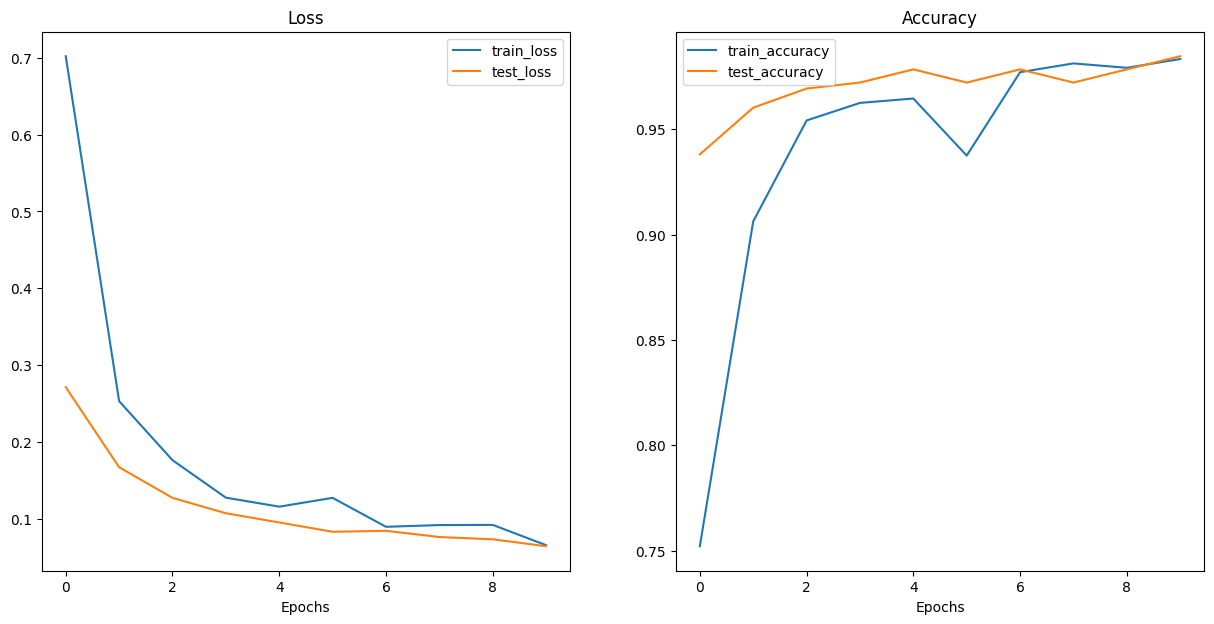

In [48]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [49]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [51]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / 1024 ** 2 # convert bytes to megabytes
print(f"Pretrain ViT Model Size: {pretrained_vit_model_size:.2f} MB")

Pretrain ViT Model Size: 327.37 MB


In [52]:
vit_total_params = sum(p.numel() for p in vit.parameters())
vit_total_params

85800963